# Notebook for Optimal Transport model 
Starting with PCA embeddings of RNA, using Linear Regression to predict how a clone responses to vaccination in a late time point, using data from P1 (initial time point) to predcit S1 and T1


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
import scirpy as ir
import anndata as ad
import scanpy as sc
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import moscot
from sklearn.metrics import mean_squared_error, r2_score

/opt/anaconda3/envs/vaccineSimulator/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get data & explore data

In [3]:
adata = sc.read_h5ad('/Users/juliakuhn/Desktop/uni/WS2425/cmscb/Project_phase/VaccineSimulator/02_dex_annotated_cd8.h5ad')
adata

AnnData object with n_obs × n_vars = 53907 × 18471
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'LTDEMIAQY', 'YTN

# Creat RNA Embeddings with PCA
Here, the sc.tl.pca was utlized, with manually selecting the number of principal components with the use of a variance ratio plot. Alternatively, one could use sklearn.PCA  
PCA embeddings are saved automatically in adata.obsm["X_pca"]

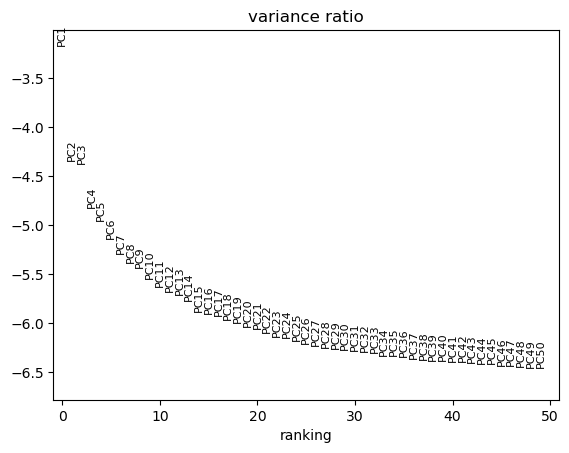

In [4]:
pca_adata = adata.copy()
sc.tl.pca(pca_adata)
sc.pl.pca_variance_ratio(pca_adata, log=True, n_pcs=50) # Elbow plot

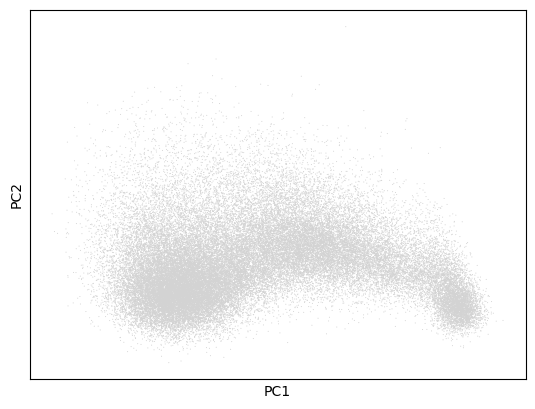

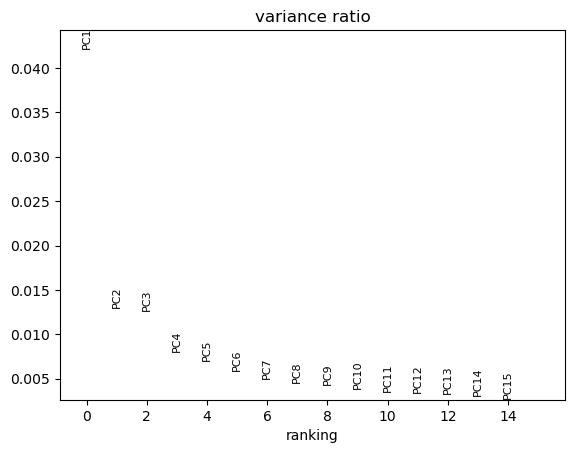

In [5]:
sc.tl.pca(adata, n_comps=15) # Perform PCA -> use 15 components since they explain 90% of the variance (plot)
sc.pl.pca(adata) # Plot only the top two principal components as they are most informative
sc.pl.pca_variance_ratio(adata, n_pcs=15) 

In [6]:
adata.obsm["X_pca"] # check if PCA was stored in adata

array([[ 7.353599  ,  2.2930684 ,  5.475095  , ..., -0.42035165,
        -0.49188307, -0.7464614 ],
       [ 8.438534  , -4.256931  ,  2.3050709 , ...,  2.3662179 ,
         0.58670783, -0.10710645],
       [-3.9699266 ,  9.784491  ,  1.751464  , ...,  2.0638733 ,
         2.7388659 , -2.1804137 ],
       ...,
       [-4.581481  , -1.3408933 ,  1.0974716 , ..., -1.164471  ,
        -1.8378661 , -0.43813595],
       [-3.7005863 , -1.7343283 , -1.1275568 , ..., -1.7393296 ,
         0.7136808 ,  0.39433032],
       [-2.018728  ,  1.920088  , -4.796494  , ...,  0.93350214,
         0.43976098,  0.09896234]], dtype=float32)

# Clone Aggregation and Pairing:
For each clone early and late time point data is paired.
Not all clones in P1 might exist in S1 or T1. Here, we ensure that only clones with valid response scores are included in the model training.

In [7]:
# filter out cells that we can't use
adata = adata[~adata.obs.clone_id.isna()]
adata = adata[~(adata.obs.clone_id=='nan')]
adata = adata[~(adata.obs.time.isin(['X3','extra']))]

In [8]:
# Filter for time points
P1_mask = adata.obs["time"] == "P1"
S1_mask = adata.obs["time"] == "S1"
T1_mask = adata.obs["time"] == "T1"

# Features: Embeddings from P1
X_p1 = adata[P1_mask].obsm["X_pca"]
X_s1 = adata[S1_mask].obsm["X_pca"]
X_t1 = adata[T1_mask].obsm["X_pca"]

# get target variable and clones from S1 and T1
S1_clones = adata[S1_mask].obs["clone_id"].values  # Clonotypes at S1
S1_targets = adata[S1_mask].obs["IFN Response_score"].values # target variable

T1_clones = adata[T1_mask].obs["clone_id"].values  # Clonotypes at T1
T1_targets = adata[T1_mask].obs["IFN Response_score"].values # target variable

P1_clones = adata[P1_mask].obs["clone_id"].values
P1_targets = adata[P1_mask].obs["IFN Response_score"].values    
unique_clonotypes_aggregated = np.unique(P1_clones) # Unique clonotypes in the aggregated data

In [9]:
# Map S1 and T1 responses to corresponding P1 clones to ensure that only clones with corresponding targets are included
s1 = np.array([S1_targets[np.where(S1_clones == cid)[0][0]] if cid in S1_clones else np.nan for cid in P1_clones])
t1 = np.array([T1_targets[np.where(T1_clones == cid)[0][0]] if cid in T1_clones else np.nan for cid in P1_clones])
p1 = np.array([P1_targets[np.where(P1_clones == cid)[0][0]] if cid in P1_clones else np.nan for cid in P1_clones])

# Remove clones without corresponding targets
valid_indices = ~np.isnan(s1) & ~np.isnan(t1)
X_p1, s1, t1, p1 = X_p1[valid_indices], s1[valid_indices], t1[valid_indices], p1[valid_indices]
P1_clones = P1_clones[valid_indices]

## Cell Pairing based on optimal transport
currently not compatible with the other snippets -> e.g can't use output for train test split based on timepoint

### P1 and S1

In [10]:
import numpy as np
import ot  # Python Optimal Transport library
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Ot pairing for P1 and S1
# Extract target IFN response scores
y_p1 = adata[P1_mask].obs["IFN Response_score"].values
y_s1 = adata[S1_mask].obs["IFN Response_score"].values

# Extract PCA embeddings and target values
X_p1 = adata[P1_mask].obsm["X_pca"]
X_s1 = adata[S1_mask].obsm["X_pca"]

# Compute cost matrix and solve OT problem
cost_matrix_s1 = ot.dist(X_p1, X_s1, metric='euclidean')
a_s1 = np.ones(len(X_p1)) / len(X_p1)
b_s1 = np.ones(len(X_s1)) / len(X_s1)
transport_plan_s1 = ot.emd(a_s1, b_s1, cost_matrix_s1)

# Extract paired indices
paired_indices_s1 = np.argwhere(transport_plan_s1 > 0)
paired_p1_indices_s1 = paired_indices_s1[:, 0]
paired_t1_indices = paired_indices_s1[:, 1]

# Prepare training data
paired_features_p1_s1 = X_p1[paired_p1_indices_s1]
paired_features_s1 = X_s1[paired_t1_indices]
paired_targets_s1 = y_s1[paired_t1_indices]

X_s1_train = np.hstack([paired_features_p1_s1, paired_features_s1])
y_s1_train = paired_targets_s1 


In [11]:
# get testing dataset - pair the cells by clonotype
# Pair cells by clonotype for the test set
clonotypes_s1 = adata[S1_mask].obs["clone_id"].values
clonotypes_p1 = adata[P1_mask].obs["clone_id"].values
common_clonotypes = np.intersect1d(clonotypes_s1, clonotypes_p1)

test_p1_indices = []
test_s1_indices = []

for clonotype in common_clonotypes:
    p1_clonotype_mask = clonotypes_p1 == clonotype
    s1_clonotype_mask = clonotypes_s1 == clonotype

    # Use the first cell from each clonotype
    test_p1_indices.append(np.where(p1_clonotype_mask)[0][0])
    test_s1_indices.append(np.where(s1_clonotype_mask)[0][0])

test_features_p1 = X_p1[test_p1_indices]
test_features_s1 = X_s1[test_s1_indices]
test_targets_s1 = y_s1[test_s1_indices]

X_s1_test = np.hstack([test_features_p1, test_features_s1])
y_s1_test = test_targets_s1

In [12]:
# Train the model
#model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model = LinearRegression()
model.fit(X_s1_train, y_s1_train)

# Test the model
y_s1_pred = model.predict(X_s1_test)

### P1 and T1

In [13]:
# OT Pairing for T1 and P1
# Extract target IFN response scores for T1
y_t1 = adata[T1_mask].obs["IFN Response_score"].values
y_p1 = adata[P1_mask].obs["IFN Response_score"].values

# Extract PCA embeddings and target values
X_p1 = adata[P1_mask].obsm["X_pca"]
X_t1 = adata[T1_mask].obsm["X_pca"]

# Compute cost matrix and solve OT problem
cost_matrix_t1 = ot.dist(X_p1, X_t1, metric='euclidean')
a_t1 = np.ones(len(X_p1)) / len(X_p1)
b_t1 = np.ones(len(X_t1)) / len(X_t1)
transport_plan_t1 = ot.emd(a_t1, b_t1, cost_matrix_t1)

# Extract paired indices
paired_indices_t1 = np.argwhere(transport_plan_t1 > 0)
paired_p1_indices_t1 = paired_indices_t1[:, 0]
paired_t1_indices = paired_indices_t1[:, 1]

# Prepare training data
paired_features_p1_t1 = X_p1[paired_p1_indices_t1]
paired_features_t1 = X_t1[paired_t1_indices]
paired_targets_t1 = y_t1[paired_t1_indices]

X_t1_train = np.hstack([paired_features_p1_t1, paired_features_t1])
y_t1_train = paired_targets_t1 


In [14]:
# get testing dataset - pair the cells by clonotype
# Pair cells by clonotype for the test set
clonotypes_t1 = adata[T1_mask].obs["clone_id"].values
clonotypes_p1 = adata[P1_mask].obs["clone_id"].values
common_clonotypes = np.intersect1d(clonotypes_t1, clonotypes_p1)

test_p1_indices = []
test_t1_indices = []

for clonotype in common_clonotypes:
    p1_clonotype_mask = clonotypes_p1 == clonotype
    t1_clonotype_mask = clonotypes_t1 == clonotype

    # Use the first cell from each clonotype
    test_p1_indices.append(np.where(p1_clonotype_mask)[0][0])
    test_t1_indices.append(np.where(t1_clonotype_mask)[0][0])

test_features_p1 = X_p1[test_p1_indices]
test_features_t1 = X_t1[test_t1_indices]
test_targets_t1 = y_t1[test_t1_indices]

X_t1_test = np.hstack([test_features_p1, test_features_t1])
y_t1_test = test_targets_t1


In [15]:
# Train the model
#model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model = LinearRegression()
model.fit(X_t1_train, y_t1_train)

# Test the model
y_t1_pred = model.predict(X_t1_test)

### Eval

In [16]:
import numpy as np

def recall_at_k(y_true, y_pred, k):
    # Get the indices of the top-k predicted scores
    top_k_pred_indices = np.argsort(y_pred)[-k:]  # Indices of top-k predicted scores
    # Get the indices of the top-k true scores
    top_k_true_indices = np.argsort(y_true)[-k:]  # Indices of top-k true scores

    # Compute intersection of predicted and true top-k indices
    intersection = np.intersect1d(top_k_pred_indices, top_k_true_indices)

    # Compute Recall@k
    recall_k = len(intersection) / k
    return recall_k


In [17]:
def aggregate_predictions_by_clonotype(y_pred):
    """
    Aggregate responses by clonotype.

    Args:
        y_pred (array-like): Responses (predicted) for each cell.

    Returns:
        dict: A dictionary mapping each clonotype to its predicted responses.
    """

    # Create an empty dictionary to store predictions for each clonotype
    predictions_by_clonotype = {}

    # Iterate over each unique clonotype in the test set
    for clonotype in np.unique(unique_clonotypes_aggregated):
        # Get indices of the test samples corresponding to this clonotype
        clonotype_mask = unique_clonotypes_aggregated == clonotype

        # Get the predicted values for this clonotype
        clonotype_predictions = y_pred[clonotype_mask]

        # Store these predictions in the dictionary
        predictions_by_clonotype[clonotype] = clonotype_predictions

    return predictions_by_clonotype


In [18]:
def recall_at_k_clonotype(y_true, y_pred, k):
    """
    Compute recall at K based on clonotype-level responsiveness.

    Args:
        y_true (array-like): True responses for each cell.
        y_pred (array-like): Predicted responses for each cell.
        k (int): Number of top clonotypes to consider.

    Returns:
        float: Recall at K based on clonotypes.

        
    """
    
    # Aggregate responses by clonotype
    true_responses_by_clonotype = aggregate_predictions_by_clonotype(y_true)
    pred_responses_by_clonotype = aggregate_predictions_by_clonotype(y_pred)

    # Sort clonotypes by their average true and predicted responses -> # TODO why? 
    top_k_true_clonotypes = sorted(
        true_responses_by_clonotype, key=true_responses_by_clonotype.get, reverse=True
    )[:k]
    top_k_pred_clonotypes = sorted(
        pred_responses_by_clonotype, key=pred_responses_by_clonotype.get, reverse=True
    )[:k]

    # Compute the intersection of top-k true and predicted clonotypes
    intersection = set(top_k_true_clonotypes) & set(top_k_pred_clonotypes)

    # Compute Recall@K
    recall_k = len(intersection) / k
    return recall_k


In [19]:
def mse_clonotype(y_pred, y_true):
    """
    Aggregate responses by clonotype and calculate MSE per clonotype.

    Args:
        y_pred (array-like): Predicted responses for each cell.
        y_true (array-like): True responses for each cell.

    Returns:
        dict: A dictionary mapping each clonotype to its predicted responses and MSE.
        float: The mean MSE across all clonotypes.
    """

    # Get the clonotype labels for the test set (assumed to be pre-defined)
    # test_clonotype_labels = unique_clonotypes_aggregated[test_mask]  # Make sure test_mask is defined
     
    # Create an empty dictionary to store predictions and MSE for each clonotype
    predictions_by_clonotype = {}
    mse_by_clonotype = {}

    # Iterate over each unique clonotype in the test set
    for clonotype in np.unique(unique_clonotypes_aggregated):
        # Get indices of the test samples corresponding to this clonotype
        clonotype_mask = clonotypes_p1 == clonotype

        # Get the predicted values and true values for this clonotype
        clonotype_predictions = y_pred[clonotype_mask]
        clonotype_true_values = y_true[clonotype_mask]

        # Calculate the MSE for this clonotype
        mse = mean_squared_error(clonotype_true_values, clonotype_predictions)

        # Store predictions and MSE in the dictionary
        predictions_by_clonotype[clonotype] = clonotype_predictions
        mse_by_clonotype[clonotype] = mse

    # Calculate the mean MSE across all clonotypes
    mean_mse = np.mean(list(mse_by_clonotype.values()))

    return mse_by_clonotype, mean_mse



In [20]:
k = 5

# Evaluate S1 predictions
mse_s1 = mean_squared_error(y_s1_test, y_s1_pred)
# mse_s1_clonotype, mse_s1_mean = mse_clonotype(y_s1_test, y_s1_pred)

"""recall_ks1 = recall_at_k_clonotype(
    y_s1_test,
    y_s1_pred,
    k
)"""
recall_ks1 = recall_at_k(y_s1_test, y_s1_pred, k)
mean_clonotype_activation_s1_predicted = y_s1_pred.mean()  # Predicted mean clonotype activation for the test set
mean_clonotype_activation_s1 = y_s1_test.mean()# True mean clonotype activation for the test set

print(f"Recall@{k} for S1: {recall_ks1:.2f}")
print(f"MSE- Mean for S1: {mse_s1}")
print(f"Mean Clonotype Activation (S1): {mean_clonotype_activation_s1:.4f}")
print(f"Mean Clonotype Activation (S1) Predicted: {mean_clonotype_activation_s1_predicted:.4f}")



# Evaluate T1 predictions
mse_t1 = mean_squared_error(y_t1_test, y_t1_pred)

# mse_t1_clonotype, mse_t1_mean = mse_clonotype(y_t1_test, y_t1_pred)
recall_kt1 = recall_at_k(y_t1_test, y_t1_pred, k)
"""recall_kt1 = recall_at_k_clonotype(
    y_t1_test,
    y_t1_pred,
    k
)"""
mean_clonotype_activation_t1 = y_t1_test.mean()
mean_clonotype_activation_t1_predicted = y_t1_pred.mean()

print(f"Recall@{k} for T1: {recall_kt1:.2f}")
print(f"MSE- Mean for T1: {mse_t1}")
print(f"Mean Clonotype Activation (T1): {mean_clonotype_activation_t1:.4f}")
print(f"Mean Clonotype Activation (T1) Predicted: {mean_clonotype_activation_t1_predicted:.4f}")

Recall@5 for S1: 0.80
MSE- Mean for S1: 0.011411892250180244
Mean Clonotype Activation (S1): -0.0373
Mean Clonotype Activation (S1) Predicted: -0.0408
Recall@5 for T1: 0.60
MSE- Mean for T1: 0.014254401437938213
Mean Clonotype Activation (T1): 0.0799
Mean Clonotype Activation (T1) Predicted: 0.0767


### Eval and Explore

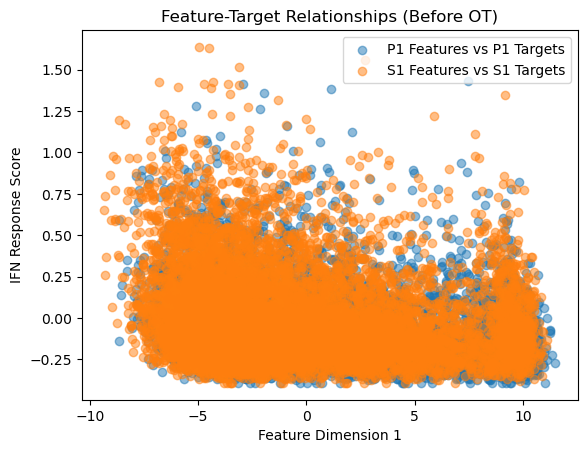

'# Scatter plot of paired features (after OT) vs targets\nplt.scatter(paired_features_p1[:, 0], paired_targets_p1, alpha=0.5, label="Paired P1 Features vs Targets")\nplt.scatter(paired_features_s1[:, 0], paired_targets_s1, alpha=0.5, label="Paired S1 Features vs Targets")\nplt.xlabel("Feature Dimension 1")\nplt.ylabel("IFN Response Score")\nplt.title("Feature-Target Relationships (After OT)")\nplt.legend()\nplt.show()'

In [22]:
# Scatter plot of original features vs targets (no OT pairing)
plt.scatter(X_p1[:, 0], y_p1, alpha=0.5, label="P1 Features vs P1 Targets")
plt.scatter(X_s1[:, 0], y_s1, alpha=0.5, label="S1 Features vs S1 Targets")
plt.xlabel("Feature Dimension 1")
plt.ylabel("IFN Response Score")
plt.title("Feature-Target Relationships (Before OT)")
plt.legend()
plt.show()

"""# Scatter plot of paired features (after OT) vs targets
plt.scatter(paired_features_p1[:, 0], paired_targets_p1, alpha=0.5, label="Paired P1 Features vs Targets")
plt.scatter(paired_features_s1[:, 0], paired_targets_s1, alpha=0.5, label="Paired S1 Features vs Targets")
plt.xlabel("Feature Dimension 1")
plt.ylabel("IFN Response Score")
plt.title("Feature-Target Relationships (After OT)")
plt.legend()
plt.show()"""


In [23]:
"""# Split data into training and testing sets
#X_s1_train, X_s1_test, y_s1_train, y_s1_test = train_test_split(X_regression, y_s1_regression, test_size=0.2, random_state=42)
X_t1_train, X_t1_test, y_t1_train, y_t1_test = train_test_split(X_regression_t1, y_regression_t1, test_size=0.2, random_state=42)

# Initialize and train the model
#model = LinearRegression()
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
#model.fit(X_s1_train, y_s1_train)
model.fit(X_t1_train, y_t1_train)


# Predict on the test set
#y_s1_pred = model.predict(X_s1_test)
y_t1_pred = model.predict(X_t1_test)"""

'# Split data into training and testing sets\n#X_s1_train, X_s1_test, y_s1_train, y_s1_test = train_test_split(X_regression, y_s1_regression, test_size=0.2, random_state=42)\nX_t1_train, X_t1_test, y_t1_train, y_t1_test = train_test_split(X_regression_t1, y_regression_t1, test_size=0.2, random_state=42)\n\n# Initialize and train the model\n#model = LinearRegression()\nmodel = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)\n#model.fit(X_s1_train, y_s1_train)\nmodel.fit(X_t1_train, y_t1_train)\n\n\n# Predict on the test set\n#y_s1_pred = model.predict(X_s1_test)\ny_t1_pred = model.predict(X_t1_test)'

In [25]:
"""# Plot feature importances
importances = model.feature_importances_
num_features = len(importances)

plt.bar(range(num_features), importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance in Gradient Boosting")
plt.show()"""

'# Plot feature importances\nimportances = model.feature_importances_\nnum_features = len(importances)\n\nplt.bar(range(num_features), importances)\nplt.xlabel("Feature Index")\nplt.ylabel("Importance")\nplt.title("Feature Importance in Gradient Boosting")\nplt.show()'

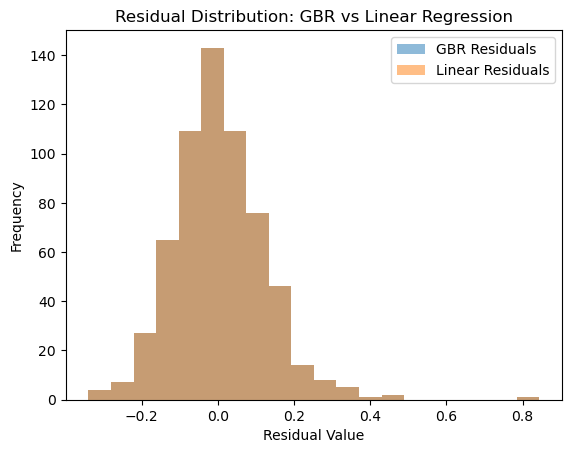

GBR MSE: 0.0143
Linear Regression MSE: 0.0143


In [26]:
# Compute residuals for GBR
gbr_residuals = y_t1_test - y_t1_pred

# Train a Linear Regression model for comparison
linear_model = LinearRegression()
linear_model.fit(X_t1_train, y_t1_train)
y_t1_linear_pred = linear_model.predict(X_t1_test)

# Compute residuals for Linear Regression
linear_residuals = y_t1_test - y_t1_linear_pred

# Plot residuals
plt.hist(gbr_residuals, bins=20, alpha=0.5, label="GBR Residuals")
plt.hist(linear_residuals, bins=20, alpha=0.5, label="Linear Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Residual Distribution: GBR vs Linear Regression")
plt.legend()
plt.show()

# Calculate residual statistics
gbr_mse = mean_squared_error(y_t1_test, y_t1_pred)
linear_mse = mean_squared_error(y_t1_test, y_t1_linear_pred)

print(f"GBR MSE: {gbr_mse:.4f}")
print(f"Linear Regression MSE: {linear_mse:.4f}")


In [27]:
k = 5

"""# Evaluate S1 predictions
mse_s1 = mean_squared_error(y_s1_test, y_s1_pred)
recall_ks1 = recall_at_k(y_s1_test, y_s1_pred, k)
mean_clonotype_activation_s1 = y_s1_test.mean()# True mean clonotype activation for the test set


print(f"Recall@{k} for S1: {recall_ks1:.2f}")
print(f"MSE for S1: {mse_s1}")
print(f"Mean Clonotype Activation (S1): {mean_clonotype_activation_s1:.4f}")"""

# Evaluate T1 predictions
mse_t1 = mean_squared_error(y_t1_test, y_t1_pred)
recall_kt1 = recall_at_k(y_t1_test, y_t1_pred, k)
#ms2_t1_gbr = mean_squared_error(y_t1_test, y_t1_pred_gbr)
mean_clonotype_activation_t1 = y_t1_test.mean()

print(f"Recall@{k} for T1: {recall_kt1:.2f}")
print(f"MSE for T1: {mse_t1}")
print(f"Mean Clonotype Activation (T1): {mean_clonotype_activation_t1:.4f}")

"""
# Plot predictions vs actual values
plt.scatter(y_s1_test, y_s1_pred, alpha=0.7)
plt.plot([y_s1_test.min(), y_s1_test.max()], [y_s1_test.min(), y_s1_test.max()], 'r--')
plt.xlabel("Actual IFN Response")
plt.ylabel("Predicted IFN Response")
plt.title("Actual vs Predicted IFN Response")
plt.show()"""

Recall@5 for T1: 0.60
MSE for T1: 0.014254401437938213
Mean Clonotype Activation (T1): 0.0799


'\n# Plot predictions vs actual values\nplt.scatter(y_s1_test, y_s1_pred, alpha=0.7)\nplt.plot([y_s1_test.min(), y_s1_test.max()], [y_s1_test.min(), y_s1_test.max()], \'r--\')\nplt.xlabel("Actual IFN Response")\nplt.ylabel("Predicted IFN Response")\nplt.title("Actual vs Predicted IFN Response")\nplt.show()'

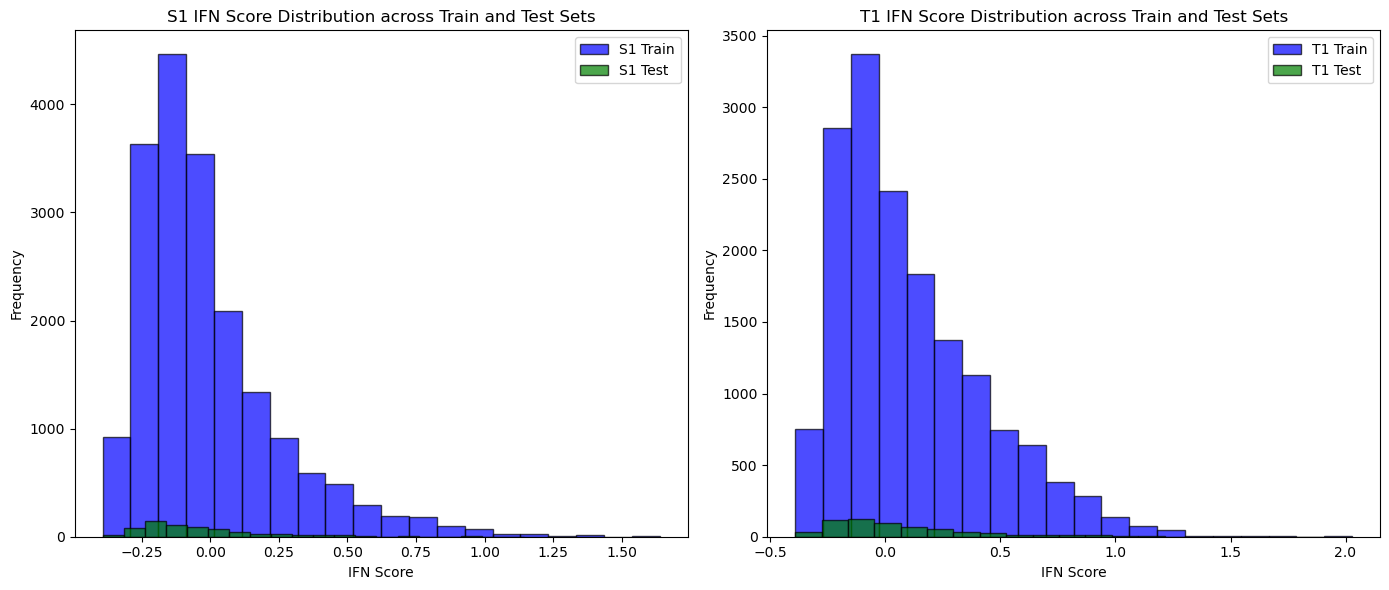

In [29]:
# plot the IFN score for train and  test subset
import matplotlib.pyplot as plt

# Plot IFN score distributions for train and test sets
plt.figure(figsize=(14, 6))

# Train distribution
plt.subplot(1, 2, 1)
plt.hist(y_s1_train, bins=20, alpha=0.7, label="S1 Train", color="blue", edgecolor="black")
plt.hist(y_s1_test, bins=20, alpha=0.7, label="S1 Test", color="green", edgecolor="black")
plt.title("S1 IFN Score Distribution across Train and Test Sets")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

# Test distribution
plt.subplot(1, 2, 2)
plt.hist(y_t1_train, bins=20, alpha=0.7, label="T1 Train", color="blue", edgecolor="black")
plt.hist(y_t1_test, bins=20, alpha=0.7, label="T1 Test", color="green", edgecolor="black")
plt.title("T1 IFN Score Distribution across Train and Test Sets")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

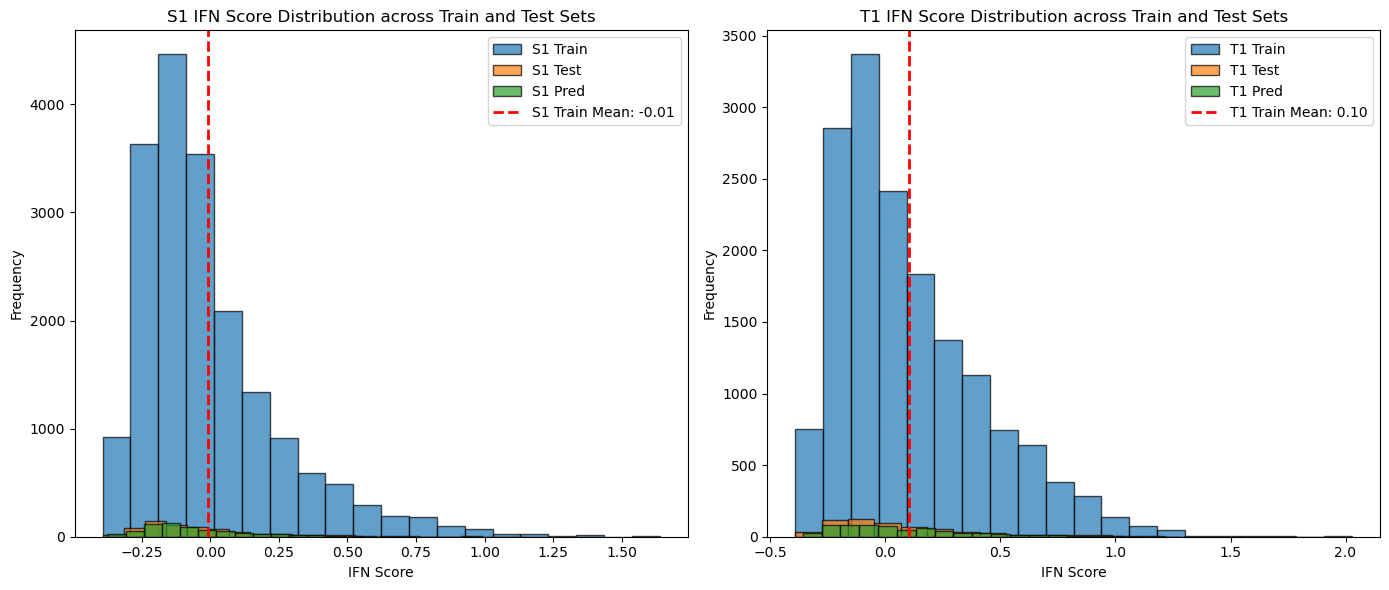

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the means of the distributions
mean_s1_train = np.mean(y_s1_train)

mean_t1_train = np.mean(y_t1_train)

# Plot IFN score distributions for train and test sets
plt.figure(figsize=(14, 6))

# Train distribution
plt.subplot(1, 2, 1)
plt.hist(y_s1_train, bins=20, alpha=0.7, label="S1 Train", edgecolor="black")
plt.hist(y_s1_test, bins=20, alpha=0.7, label="S1 Test", edgecolor="black")
plt.hist(y_s1_pred, bins=20, alpha=0.7, label="S1 Pred", edgecolor="black")
plt.axvline(mean_s1_train, color='red', linestyle='dashed', linewidth=2, label=f"S1 Train Mean: {mean_s1_train:.2f}")
plt.title("S1 IFN Score Distribution across Train and Test Sets")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

# Test distribution
plt.subplot(1, 2, 2)
plt.hist(y_t1_train, bins=20, alpha=0.7, label="T1 Train", edgecolor="black")
plt.hist(y_t1_test, bins=20, alpha=0.7, label="T1 Test", edgecolor="black")
plt.hist(y_t1_pred, bins=20, alpha=0.7, label="T1 Pred", edgecolor="black")
plt.axvline(mean_t1_train, color='red', linestyle='dashed', linewidth=2, label=f"T1 Train Mean: {mean_t1_train:.2f}")
plt.title("T1 IFN Score Distribution across Train and Test Sets")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()
